# CNN experience

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import soundata
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input


In [42]:
def load_and_prepare_data():
    "loads the images and their according class"
    all_images = []
    all_labels = []
    print("Loading images..")
    for fold in range(1,11):
        path = os.path.join('images_cnn', f"fold{fold}")
        images, labels = load_images_from_path(path)
        all_images.append( images)
        all_labels.append(labels)
    print("Finished loading Images.")

    return all_images, all_labels
        

In [43]:
from keras.preprocessing import image

#to open images and labels 
def load_images_from_path(path):

    #order of images and labels match 
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        
        #extract the class from the filename
        filename = os.path.splitext(file)[0]  # Remove file extension
        label = filename.split('_')[-1]  # Extract label after the underscore
        labels.append(int(label))
        
    return images, labels

In [44]:
##evaluating the models 

def evaluate_model(model_function, images, labels, model_name="Model", num_folds=10, epochs=30, batch_size=32, seed=42):
    """
    Evaluate a model using k-fold cross-validation and return performance metrics.
    """
    # Clear previous session and set random seeds
    tf.keras.backend.clear_session()
    
    val_accuracies = []
    test_accuracies = []
    histories = []

    # Cross-validation loop - using one fold as computational time takes too long 
    for i in range(1):
        print(f"\nTraining {model_name} - Fold {i+1}/{num_folds}")
        
        # Define train, validation and test sets for this fold
        test_fold = i
        val_fold = (i + 1) % num_folds
        train_folds = [f for f in range(num_folds) if f not in [test_fold, val_fold]]
        
        # Combine training data (8 folds)
        train_images = np.concatenate([images[f] for f in train_folds])
        train_labels = np.concatenate([labels[f] for f in train_folds])
        
        # Get validation data (1 fold)
        val_images = np.array(images[val_fold])
        val_labels = np.array(labels[val_fold])
        
        # Get test data (1 fold)
        test_images = np.array(images[test_fold])
        test_labels = np.array(labels[test_fold])
        
        # Create and train model
        model = model_function()
        
        # Train using validation data
        history = model.fit(
            train_images, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_images, val_labels),
            verbose=0
        )
        
        histories.append(history.history)

    #calculates mean values for the validation across all apochs
    mean_val_accuracy = np.mean(history.history['val_accuracy'])
    mean_val_loss = np.mean(history.history['val_loss'])
    mean_training_accuracy = np.mean(history.history['accuracy'])
    mean_training_loss = np.mean(history.history['loss'])

    print(f"Fold {i+1} Validation Accuracy: {mean_val_accuracy:.4f}\nValidation loss: {mean_val_loss:.4f}\nTraining Accuracy: {mean_training_accuracy:.4f}\nTraining mean loss:{mean_training_loss:.4f}\n")
    return history.history

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(models, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Creates separate plots for losses and accuracies for model performance.
    
    Parameters:
        models (list): List of model names.
        train_losses (list): List of mean training losses.
        val_losses (list): List of mean validation losses.
        train_accuracies (list): List of mean training accuracies.
        val_accuracies (list): List of mean validation accuracies.
    """
    x = np.arange(len(models))  # X-axis positions for each model

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ---- Plotting Losses ----
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Loss', color='tab:orange')

    # Plotting training and validation losses with different shades of orange
    ax1.scatter(x, train_losses, label='Train Loss', color='darkorange', s=100, marker='o', zorder=5)
    ax1.scatter(x, val_losses, label='Val Loss', color='orangered', s=100, marker='s', zorder=5)
    
    # Annotating loss points with the exact values (4 decimal places)
    for i, txt in enumerate(train_losses):
        ax1.annotate(f'{txt:.4f}', (x[i], train_losses[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='darkorange')
    for i, txt in enumerate(val_losses):
        ax1.annotate(f'{txt:.4f}', (x[i], val_losses[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='orangered')

    ax1.set_xticks(x)  # Positioning x-ticks in the center of each model group
    ax1.set_xticklabels(models)  # Label models on the x-axis

    # ---- Plotting Accuracies ----
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Accuracy', color='tab:blue')

    # Plotting training and validation accuracies with different shades of blue
    ax2.scatter(x, train_accuracies, label='Train Accuracy', color='mediumblue', s=100, marker='o', zorder=5)
    ax2.scatter(x, val_accuracies, label='Val Accuracy', color='skyblue', s=100, marker='s', zorder=5)

    # Annotating accuracy points with the exact values (4 decimal places)
    for i, txt in enumerate(train_accuracies):
        ax2.annotate(f'{txt:.4f}', (x[i], train_accuracies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='darkblue')
    for i, txt in enumerate(val_accuracies):
        ax2.annotate(f'{txt:.4f}', (x[i], val_accuracies[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='steelblue')

    ax2.set_xticks(x)  # Positioning x-ticks in the center of each model group
    ax2.set_xticklabels(models)  # Label models on the x-axis

    # Adding legends outside the plot area
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Losses", fontsize=10, title_fontsize=12)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5), title="Accuracies", fontsize=10, title_fontsize=12)

    # Adding space for the legends
    fig.tight_layout()  # Adjust layout for better fit

    # Display the plot
    plt.show()


In [46]:
images, labels = load_and_prepare_data()   

Loading images..
Finished loading Images.


# Experiences with different numbers of layers

In [47]:
##creating different models 
def cnn_model1(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 3 concolutional layers filters(16->32->64)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
        
            MaxPooling2D((2, 2)),
            
            Conv2D(32, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def cnn_model2(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def cnn_model3(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 2 convolutional layers filters(16->32)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [48]:
# Define a list to hold results for multiple models
all_results = []

# Example: Evaluate multiple models
for model_function, model_name in [(cnn_model1, "Model 1"), (cnn_model2, "Model 2"), (cnn_model3, "Model 3")]:
    history = evaluate_model(model_function, images, labels, model_name=model_name, num_folds=10)
    history['model_name'] = model_name  # Add model name to the results for identification
    all_results.append(history)



Training Model 1 - Fold 1/10
Fold 1 Validation Accuracy: 0.5686
Validation loss: 2.4576
Training Accuracy: 0.9499
Training mean loss:0.1670


Training Model 2 - Fold 1/10
Fold 1 Validation Accuracy: 0.5677
Validation loss: 2.3400
Training Accuracy: 0.9475
Training mean loss:0.1673


Training Model 3 - Fold 1/10
Fold 1 Validation Accuracy: 0.5100
Validation loss: 2.7046
Training Accuracy: 0.9588
Training mean loss:0.1398



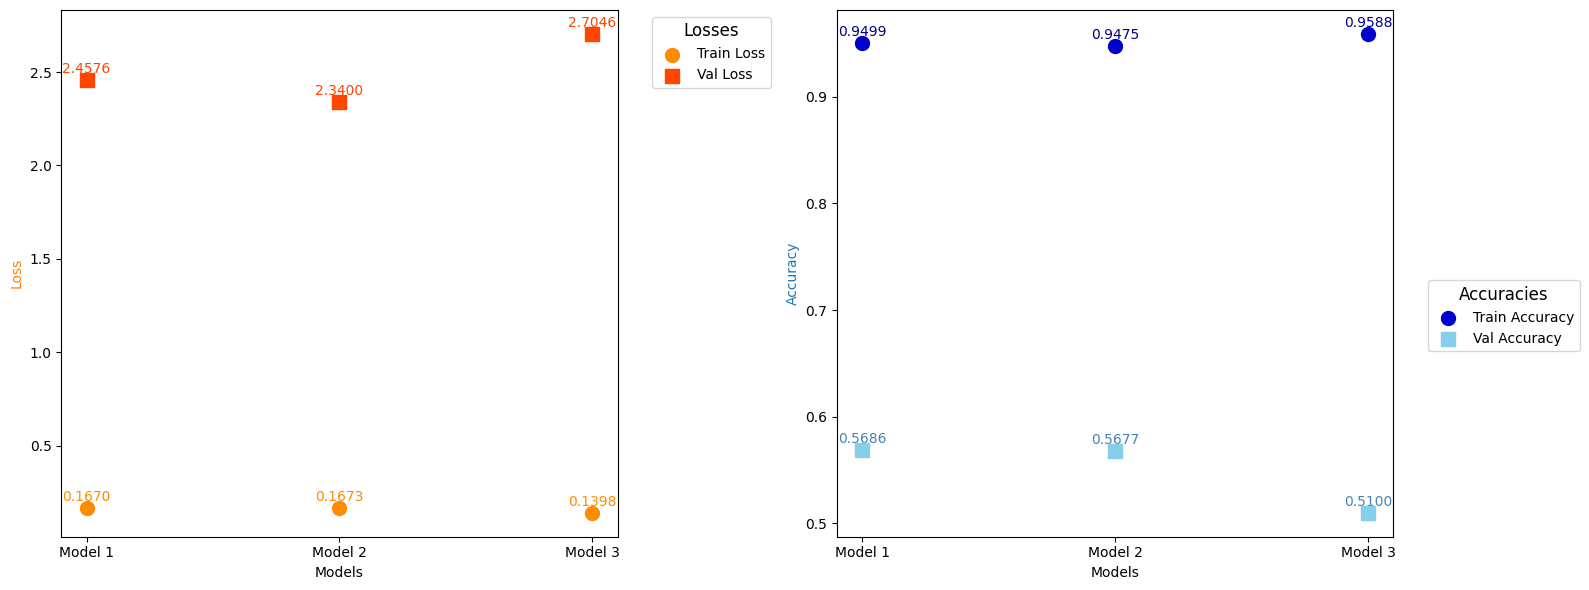

In [49]:
# Initialize lists for plotting
model_names = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Extract data for each model
for result in all_results:
    model_names.append(result['model_name'])
    train_losses.append(np.mean(result['loss']))
    val_losses.append(np.mean(result['val_loss']))
    train_accuracies.append(np.mean(result['accuracy']))
    val_accuracies.append(np.mean(result['val_accuracy']))

plot_model_performance(model_names, train_losses, val_losses, train_accuracies, val_accuracies)



# Testing optimizers based on Model 2 


In [50]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD


def cnn_model2_adam(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   #learning rate is default 0.001
    return model



def cnn_model2_SGD(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



def cnn_model2_RMSprop(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model





def cnn_model2_Adadelta(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    model.compile(optimizer=Adadelta(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [51]:
# Define a list to hold results for multiple models
all_results_op = []

# Example: Evaluate multiple models
for model_function, model_name in [(cnn_model2_adam, "Model O: Adam"), (cnn_model2_SGD, "Model O: SGD"), (cnn_model2_RMSprop, "Model O: RMSprop"), (cnn_model2_Adadelta,"Model O: Adadelta")]:
    history = evaluate_model(model_function, images, labels, model_name=model_name, num_folds=10)
    history['model_name'] = model_name  # Add model name to the results for identification
    all_results_op.append(history)


Training Model O: Adam - Fold 1/10
Fold 1 Validation Accuracy: 0.5866
Validation loss: 2.1181
Training Accuracy: 0.9504
Training mean loss:0.1610


Training Model O: SGD - Fold 1/10
Fold 1 Validation Accuracy: 0.5962
Validation loss: 1.1709
Training Accuracy: 0.8364
Training mean loss:0.5319


Training Model O: RMSprop - Fold 1/10
Fold 1 Validation Accuracy: 0.5851
Validation loss: 2.5609
Training Accuracy: 0.9545
Training mean loss:0.1423


Training Model O: Adadelta - Fold 1/10
Fold 1 Validation Accuracy: 0.3799
Validation loss: 1.8054
Training Accuracy: 0.4004
Training mean loss:1.8979



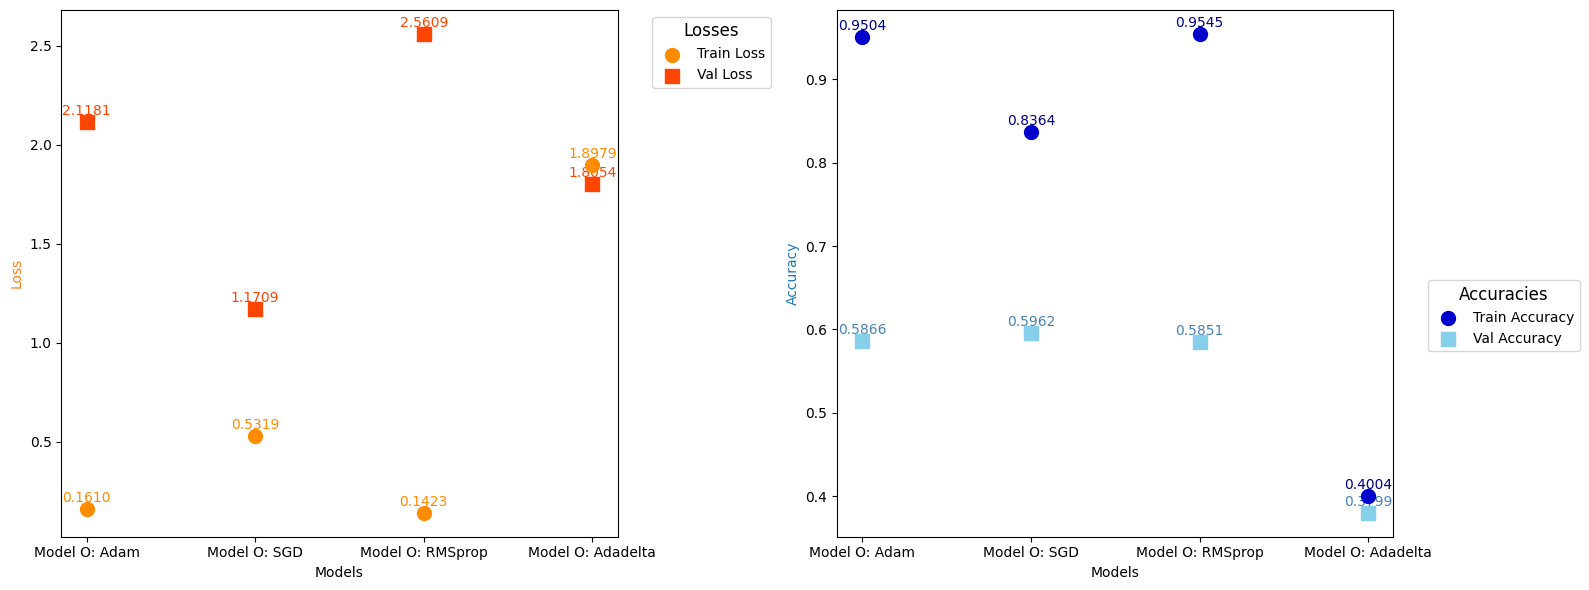

In [53]:
# Initialize lists for plotting
model_names = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Extract data for each model
for result in all_results_op:
    model_names.append(result['model_name'])
    train_losses.append(np.mean(result['loss']))
    val_losses.append(np.mean(result['val_loss']))
    train_accuracies.append(np.mean(result['accuracy']))
    val_accuracies.append(np.mean(result['val_accuracy']))

plot_model_performance(model_names, train_losses, val_losses, train_accuracies, val_accuracies)


## Testing different learning rates

In [54]:
def cnn_model2_SGD1(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_model2_SGD2(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_model2_SGD3(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def cnn_model2_SGD4(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
# Define a list to hold results for multiple models
all_results_lr = []

# Example: Evaluate multiple models
for model_function, model_name in [(cnn_model2_SGD1, "LR: 0.001"), (cnn_model2_SGD2, "LR: 0.01"), (cnn_model2_SGD3, "LR: 0.0001"), (cnn_model2_SGD4,"LR: 0.005")]:
    history = evaluate_model(model_function, images, labels, model_name=model_name, num_folds=10)
    history['model_name'] = model_name  # Add model name to the results for identification
    all_results_lr.append(history)


Training LR: 0.001 - Fold 1/10
Fold 1 Validation Accuracy: 0.5756
Validation loss: 1.2961
Training Accuracy: 0.8234
Training mean loss:0.5848


Training LR: 0.01 - Fold 1/10
Fold 1 Validation Accuracy: 0.6539
Validation loss: 1.2082
Training Accuracy: 0.9358
Training mean loss:0.2172


Training LR: 0.0001 - Fold 1/10
Fold 1 Validation Accuracy: 0.4797
Validation loss: 1.4302
Training Accuracy: 0.5682
Training mean loss:1.3003


Training LR: 0.005 - Fold 1/10
Fold 1 Validation Accuracy: 0.6219
Validation loss: 1.2419
Training Accuracy: 0.9192
Training mean loss:0.2743



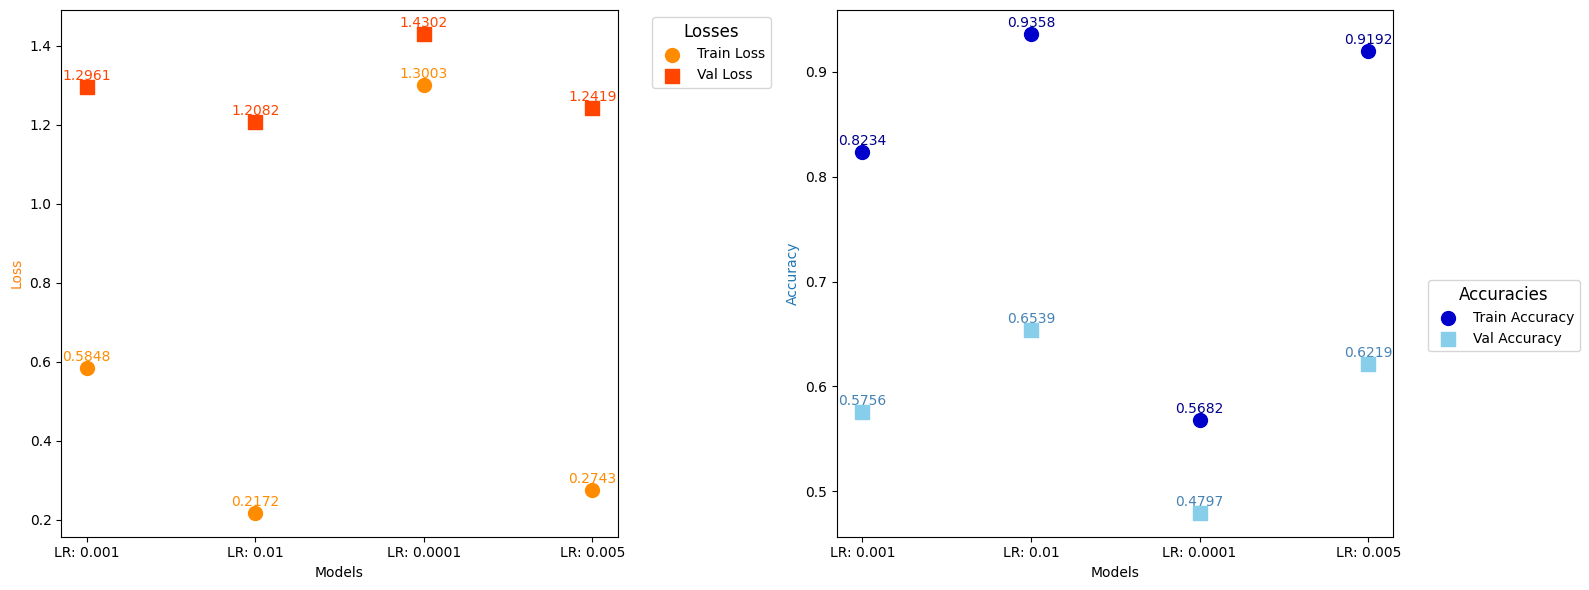

In [56]:
# Initialize lists for plotting
model_names = []
train_losses = []
val_losses = []ﬂ
train_accuracies = []
val_accuracies = []

# Extract data for each model
for result in all_results_lr:
    model_names.append(result['model_name'])
    train_losses.append(np.mean(result['loss']))
    val_losses.append(np.mean(result['val_loss']))
    train_accuracies.append(np.mean(result['accuracy']))
    val_accuracies.append(np.mean(result['val_accuracy']))

plot_model_performance(model_names, train_losses, val_losses, train_accuracies, val_accuracies)

# Testing different dropout rates

In [57]:
def cnn_model2_SGD2_d1(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_model2_SGD2_d2(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def cnn_model2_SGD2_d3(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.7),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [58]:
# Define a list to hold results for multiple models
all_results_dr = []

# Example: Evaluate multiple models
for model_function, model_name in [(cnn_model2_SGD2_d1, "DR: 0.5"), (cnn_model2_SGD2_d2, "DR: 0.2"), (cnn_model2_SGD2_d3, "DR: 0.7")]:
    history = evaluate_model(model_function, images, labels, model_name=model_name, num_folds=10)
    history['model_name'] = model_name  # Add model name to the results for identification
    all_results_dr.append(history)


Training DR: 0.5 - Fold 1/10
Fold 1 Validation Accuracy: 0.6162
Validation loss: 2.9025
Training Accuracy: 0.9397
Training mean loss:0.2093


Training DR: 0.2 - Fold 1/10
Fold 1 Validation Accuracy: 0.6364
Validation loss: 1.3944
Training Accuracy: 0.9652
Training mean loss:0.1259


Training DR: 0.7 - Fold 1/10
Fold 1 Validation Accuracy: 0.6447
Validation loss: 1.3455
Training Accuracy: 0.9040
Training mean loss:0.3203



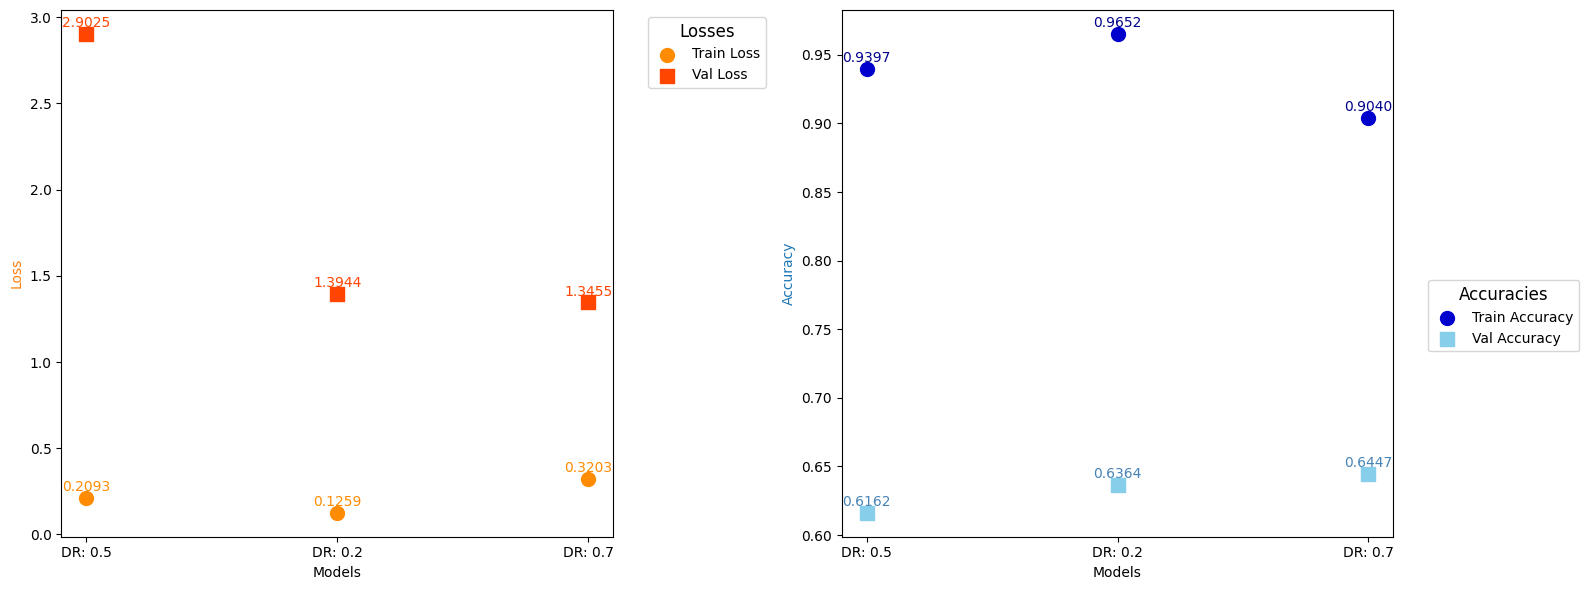

In [60]:
# Initialize lists for plotting
model_names = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Extract data for each model
for result in all_results_dr:
    model_names.append(result['model_name'])
    train_losses.append(np.mean(result['loss']))
    val_losses.append(np.mean(result['val_loss']))
    train_accuracies.append(np.mean(result['accuracy']))
    val_accuracies.append(np.mean(result['val_accuracy']))

plot_model_performance(model_names, train_losses, val_losses, train_accuracies, val_accuracies)

## Testing different epochs 


In [63]:
def cnn_model(num_classes = 10, height = 224, width = 224, channels = 3):
    "First implementation: 4 convolutional layers filters(16->32->64->128)"
    model = Sequential([
        
            Input(shape=(height, width, channels)),
        
            Conv2D(16, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(32, (3, 3), activation='relu'),  # Set height, width, and channels based on your input
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            
            Conv2D(64, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Conv2D(128, (3, 3), activation='relu'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
        
            Flatten(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.7),
            
            Dense(num_classes, activation='softmax')
        ])
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
# Define a list to hold results for multiple models
all_results_e = []

epochs = [5,20,50,100]

# Example: Evaluate multiple models
for epoch in epochs :
    history = evaluate_model(cnn_model, images, labels,epochs = epoch, model_name=epoch, num_folds=10)
    history['epochs'] = epoch  # Add model name to the results for identification
    all_results_e.append(history)


Training 5 - Fold 1/10
Fold 1 Validation Accuracy: 0.4777
Validation loss: 1.6192
Training Accuracy: 0.6378
Training mean loss:1.1226


Training 20 - Fold 1/10
Fold 1 Validation Accuracy: 0.6093
Validation loss: 1.2772
Training Accuracy: 0.8468
Training mean loss:0.4995


Training 50 - Fold 1/10
Fold 1 Validation Accuracy: 0.6477
Validation loss: 1.2841
Training Accuracy: 0.9234
Training mean loss:0.2600


Training 100 - Fold 1/10
Fold 1 Validation Accuracy: 0.6739
Validation loss: 1.4757
Training Accuracy: 0.9638
Training mean loss:0.1274



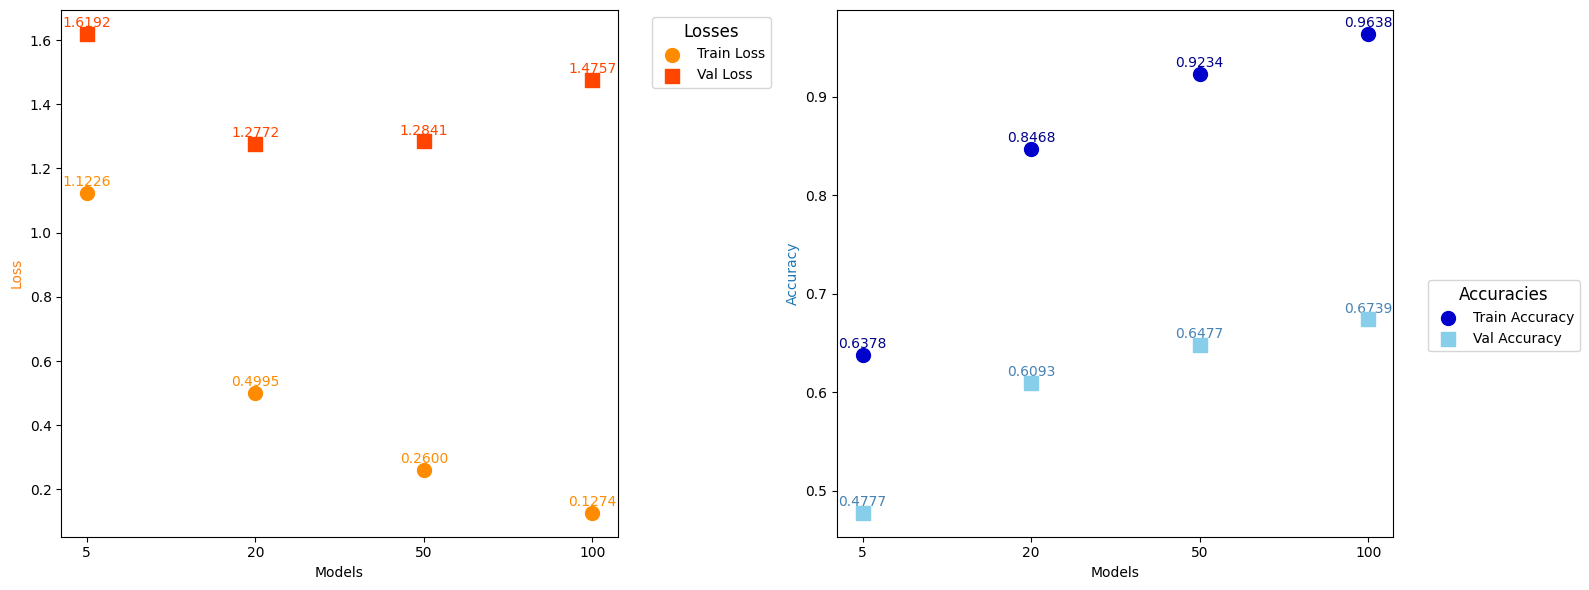

In [69]:
# Initialize lists for plotting
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Extract data for each model
for result in all_results_e:
    epochs.append(result['epochs'])
    train_losses.append(np.mean(result['loss']))
    val_losses.append(np.mean(result['val_loss']))
    train_accuracies.append(np.mean(result['accuracy']))
    val_accuracies.append(np.mean(result['val_accuracy']))

plot_model_performance(epochs, train_losses, val_losses, train_accuracies, val_accuracies)